In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.mixture import BayesianGaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Đọc dữ liệu

In [2]:
df = pd.read_csv('/kaggle/input/data-th/data.csv', encoding='latin-1', sep=';')
df.head(5)

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


- Chọn cột dữ liệu theo mã sinh viên

In [3]:
feats = ['1']

### 2. Sử dụng Bayesian Gaussian Mixture

- Scale dữ liệu

In [4]:
transformer = StandardScaler()
X = transformer.fit_transform(np.array(df[feats]).reshape(-1, 1))

- Dữ liệu sau khi scale

In [5]:
X[:5]

array([[-0.72216308],
       [-0.19550973],
       [-0.49359743],
       [-0.3640769 ],
       [ 0.20257544]])

- Sử dụng phương pháp Elbow để xác định số cụm

Elbow Method to determine the number of clusters to be formed:


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

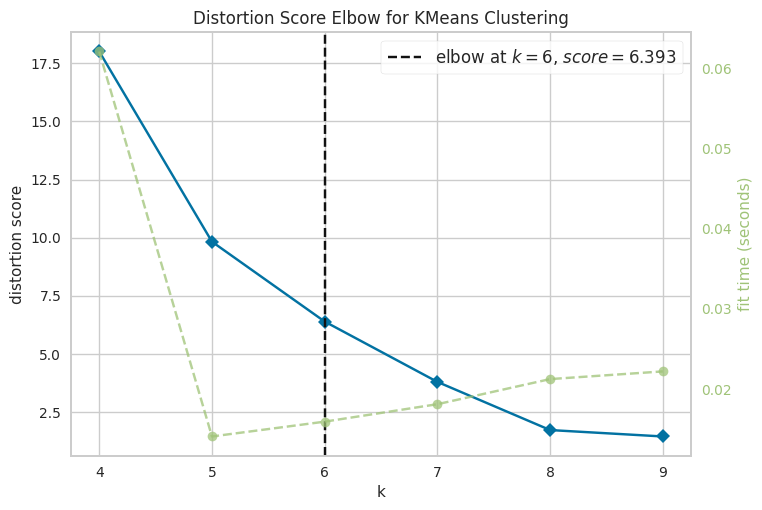

In [6]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=23), k=(4,10))
Elbow_M.fit(X)
Elbow_M.show();

- Thử nghiệm với K = 6

In [7]:
BGM = BayesianGaussianMixture(n_components=6,covariance_type='full',random_state=1,n_init=12)
# fit model and predict clusters
preds = BGM.fit_predict(X)
#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= preds

In [8]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(6)]]=pp 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(6):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

- Tạo bộ phân loại

In [9]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=11.
  warnings.warn(


[200]	valid_0's multi_logloss: 0.000300121
[200]	valid_0's multi_logloss: 0.000304491
[400]	valid_0's multi_logloss: 0.000304491
[200]	valid_0's multi_logloss: 0.000278214
[200]	valid_0's multi_logloss: 0.000171512
[400]	valid_0's multi_logloss: 0.000170935
[600]	valid_0's multi_logloss: 0.000170773
[800]	valid_0's multi_logloss: 0.000170697
[1000]	valid_0's multi_logloss: 0.000170654
[1200]	valid_0's multi_logloss: 0.000170626
[1400]	valid_0's multi_logloss: 0.000170607
[1600]	valid_0's multi_logloss: 0.000170592
[1800]	valid_0's multi_logloss: 0.000170581
[2000]	valid_0's multi_logloss: 0.000170573
[2200]	valid_0's multi_logloss: 0.000170566
[2400]	valid_0's multi_logloss: 0.00017056
[2600]	valid_0's multi_logloss: 0.000170555
[2800]	valid_0's multi_logloss: 0.000170551
[3000]	valid_0's multi_logloss: 0.000170547
[3200]	valid_0's multi_logloss: 0.000170544
[3400]	valid_0's multi_logloss: 0.000170542
[3600]	valid_0's multi_logloss: 0.000170539
[3800]	valid_0's multi_logloss: 0.0001705

In [10]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [11]:
labels=np.argmax(lgb_preds,axis=1)

- Nhãn của từng điểm dữ liệu sau khi training xong

In [12]:
labels

array([0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 0, 0, 0,
       0, 0, 3, 0, 2, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2,
       2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,

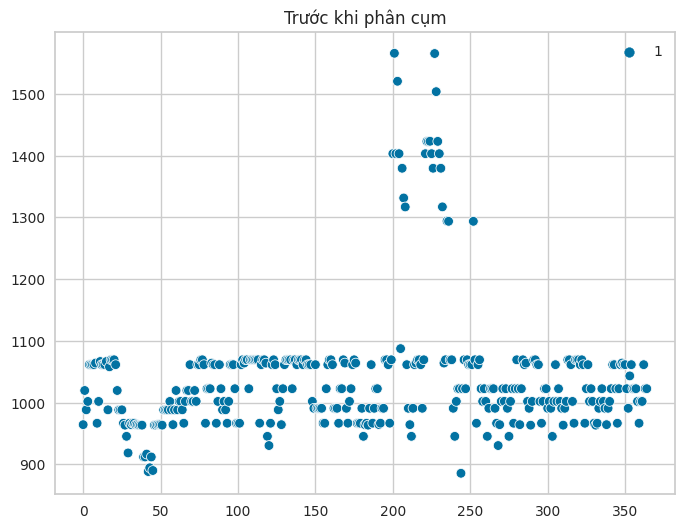

In [13]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(label="bla")
sns.scatterplot(df[feats], marker='o');
ax.set_title("Trước khi phân cụm");

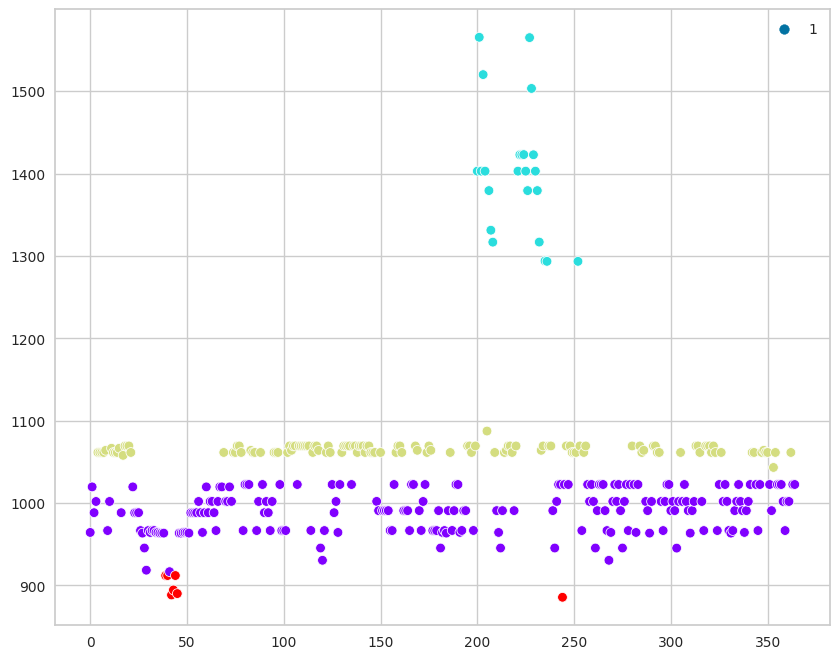

In [14]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(df[feats], c=df["Clusters"], marker='o',cmap="rainbow");
ax.set_title("Sau khi phân cụm");
plt.show();

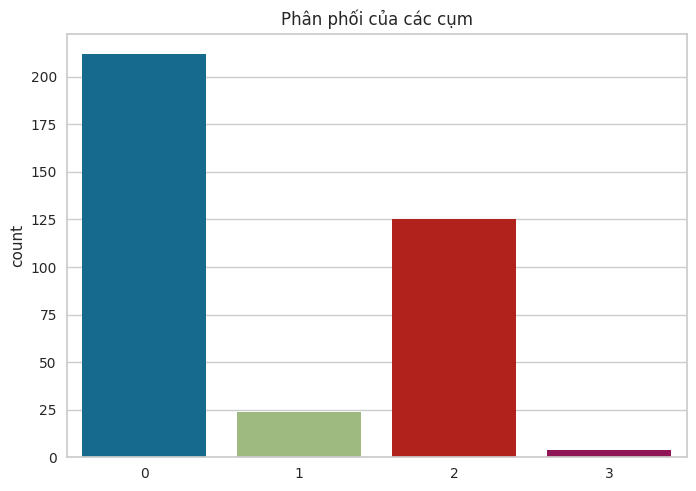

In [15]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Phân phối của các cụm")
plt.show()

### 3. Sử dụng LSTM để dự đoán giá trị tương lai

In [16]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

2024-05-07 02:03:18.071905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 02:03:18.072035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 02:03:18.231851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
df = df.iloc[:, :2]

In [18]:
df

,Ngày,1
0,01/01/2021,964.4
1,01/02/2021,1019.7
2,01/03/2021,988.4
3,01/04/2021,1002.0
4,01/05/2021,1061.5
...,...,...
360,27/12/2021,1002.0
361,28/12/2021,1002.0
362,29/12/2021,1061.5
363,30/12/2021,1022.6


- Chuyển format ngày

In [19]:
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')
df.sort_values(by='Ngày', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

- Tạo số dữ liệu test bằng tháng 12

In [20]:
test_size = df[df['Ngày'].dt.month==12].shape[0]
test_size

31

Biểu đồ thể hiện training và test trước khi dự đoán

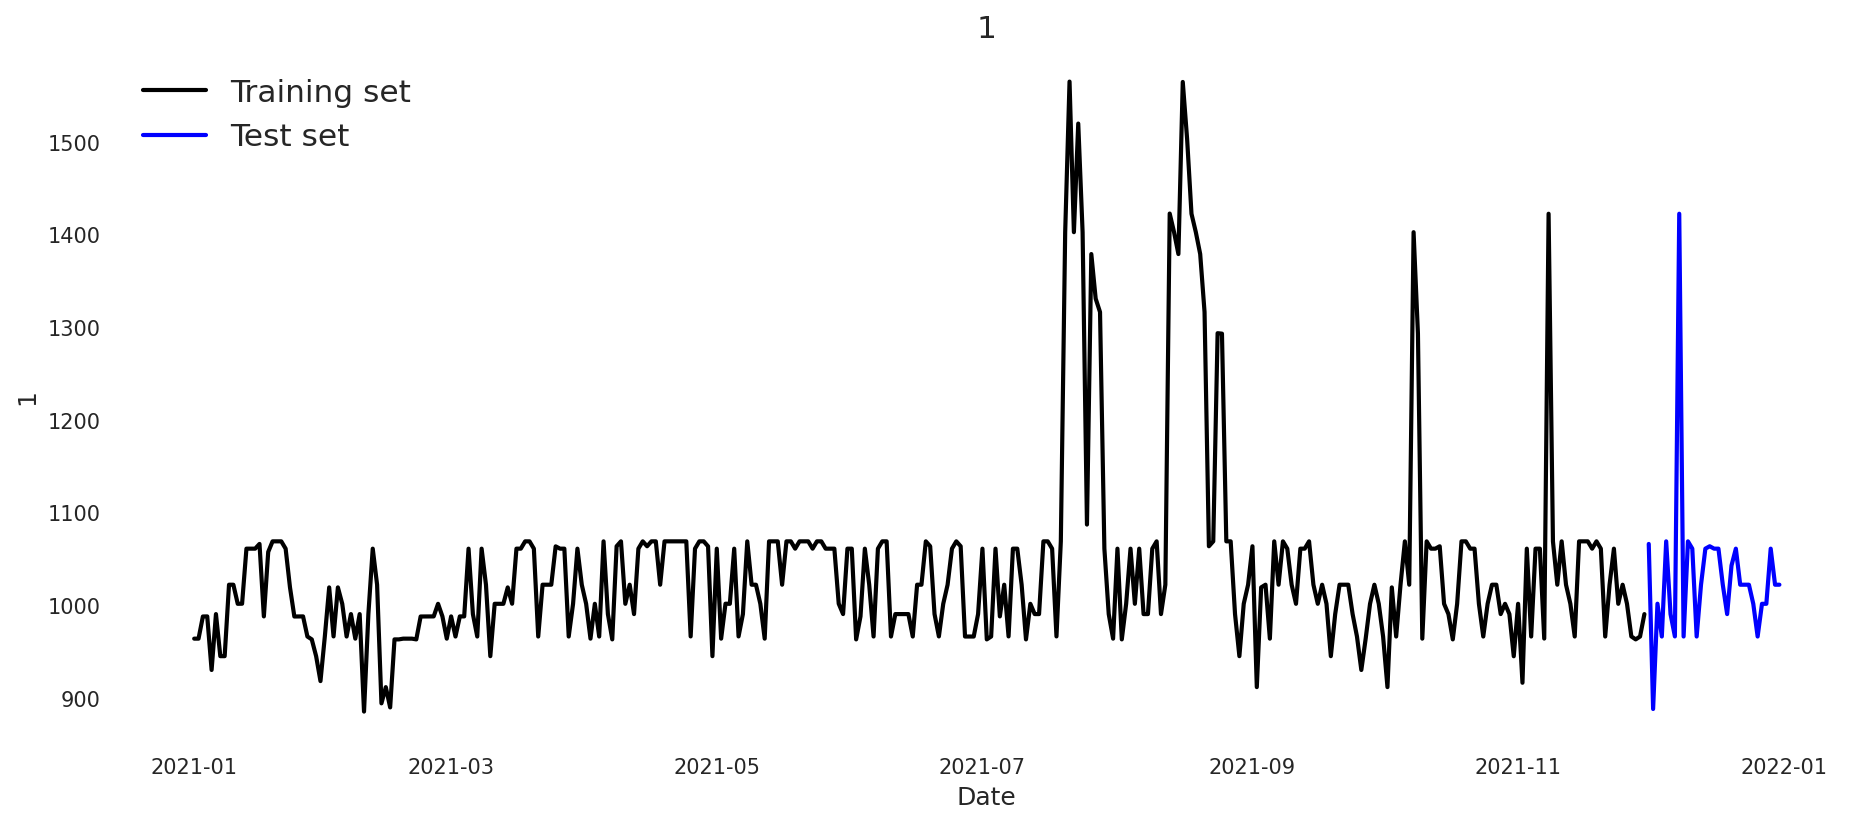

In [21]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'][:-test_size], df['1'][:-test_size], color='black', lw=2)
plt.plot(df['Ngày'][-test_size:], df['1'][-test_size:], color='blue', lw=2)
plt.title('1', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('1', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

- Biểu đồ thể hiện toàn bộ dữ liệu

In [22]:
import plotly.express as px
fig = px.line(y=df['1'], x=df['Ngày'])
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Ngày", 
                  yaxis_title="1",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')

- Sử dụng MinMaxScaler để đưa dữ liệu về khoảng 0-1

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df['1'].values.reshape(-1,1))

MinMaxScaler()

- Chọn window_size = 15 tức là 15 ngày dự đoán cho 1 ngày tiếp theo

In [24]:
window_size = 15

- Tạo tập training data

In [25]:
train_data = df['1'][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [26]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

- Tạo tập test data

In [27]:
test_data = df['1'][-test_size-window_size:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [28]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

- Chuyển đổi dữ liệu từ dataframe, series sang numpy array

In [29]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [30]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [31]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (319, 15, 1)
y_train Shape:  (319, 1)
X_test Shape:   (31, 15, 1)
y_test Shape:   (31, 1)


- Khởi tạo model

In [32]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64)(input1)  
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

- Tạo bộ siêu tham số: epochs=30 (lặp 30 lần)

In [33]:
model = define_model()
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0612 - val_loss: 0.0192
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0411 - val_loss: 0.0157
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0216 - val_loss: 0.0163
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0202 - val_loss: 0.0163
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0265 - val_loss: 0.0157
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0243 - val_loss: 0.0161
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0312 - val_loss: 0.0155
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0249 - val_loss: 0.0155
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0235 - val_loss: 0.0156
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0261 - val_loss: 0.0157
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0238 - val_loss: 0.0158
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 - val_l

- Dự đoán

In [34]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0171
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


In [35]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [36]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.017139215022325516
Test MAPE: 1.6466625364518959
Test Accuracy: -0.6466625364518959


In [37]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

- Vẽ biểu đồ sau khi đã tự đoán

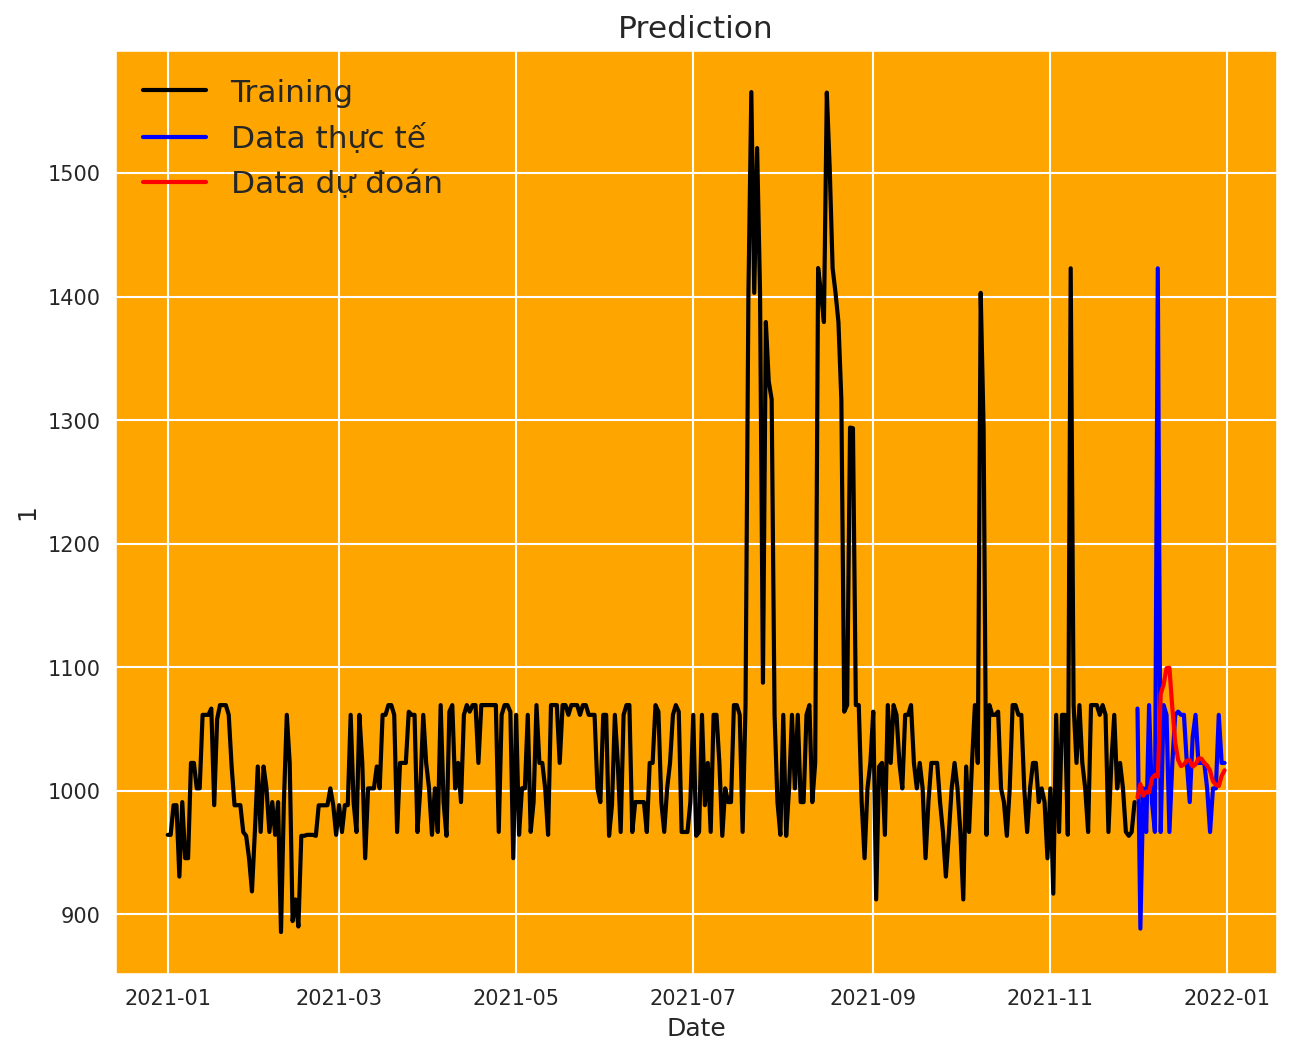

In [38]:
plt.figure(figsize=(10, 8), dpi=150)
plt.rcParams['axes.facecolor'] = 'orange'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('1', fontsize=12)
plt.legend(['Training', 'Data thực tế', 'Data dự đoán'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()